In [1]:
! pip install datasets transformers trl wandb

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached trl-0.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached GitPython-3.1.44-py3-none-any.whl.metadata (13 kB)
  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached sentry_sdk-2.20.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.5.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6

## Test 1


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm
from trl import DPOConfig, DPOTrainer

os.environ["WANDB_DISABLED"] = "true"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 2
BETA = 0.1
BATCH_SIZE = 1
LR = 1e-6
MODEL_NAME = "facebook/opt-125m"
DATASET_NAME = "jondurbin/truthy-dpo-v0.1"
SEED = 2003

def seed_all(seed=2003):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed_all(SEED)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)
ref_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

def calculate_DPO_loss(model_preferred_logprob, model_dispreferred_logprob,
                       ref_preferred_logprob, ref_dispreferred_logprob,
                       beta=0.5):
    preferred_relative_logprob = model_preferred_logprob - ref_preferred_logprob
    dispreferred_relative_logprob = model_dispreferred_logprob - ref_dispreferred_logprob

    reward_accuracies = (preferred_relative_logprob > dispreferred_relative_logprob).float().mean()
    reward_margins = (preferred_relative_logprob - dispreferred_relative_logprob).mean()

    loss = -F.logsigmoid(beta * (preferred_relative_logprob - dispreferred_relative_logprob)).mean()

    return loss, preferred_relative_logprob.mean(), dispreferred_relative_logprob.mean(), reward_accuracies, reward_margins

def get_log_prob(logits, labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

def preprocess_data(item, tokenizer):
    prompt = 'Instruct: ' + item['prompt'] + '\n'
    chosen = 'Output: ' + item['chosen']
    rejected = 'Output: ' + item['rejected']

    prompt_preferred = tokenizer(prompt + chosen, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    prompt_dispreferred = tokenizer(prompt + rejected, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    
    
    

    return {
        'prompt_preferred_ids': prompt_preferred['input_ids'].squeeze(0),
        'prompt_dispreferred_ids': prompt_dispreferred['input_ids'].squeeze(0),
        'prompt_preferred_mask': prompt_preferred['attention_mask'].squeeze(0),
        'prompt_dispreferred_mask': prompt_dispreferred['attention_mask'].squeeze(0),
    }

def prepare_dataloader(dataset, tokenizer, batch_size=1):
    dataset = dataset.map(lambda x: preprocess_data(x, tokenizer))
    dataset.set_format(type="torch", columns=['prompt_preferred_ids', 'prompt_dispreferred_ids', 'prompt_preferred_mask', 'prompt_dispreferred_mask'])
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = load_dataset(DATASET_NAME, split="train")
train_dataloader = prepare_dataloader(dataset, tokenizer, batch_size=BATCH_SIZE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def train_custom_DPO(model, ref_model, tokenizer, optimizer, train_dataloader, epochs=1, beta=0.1):
    model.train()
    ref_model.eval()

    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            prompt_preferred_ids = batch['prompt_preferred_ids'].to(model.device)
            prompt_dispreferred_ids = batch['prompt_dispreferred_ids'].to(model.device)
            mask_preferred = batch['prompt_preferred_mask'].to(model.device)
            mask_dispreferred = batch['prompt_dispreferred_mask'].to(model.device)

            model_preferred_log_prob = get_log_prob(model(prompt_preferred_ids, attention_mask=mask_preferred).logits, prompt_preferred_ids)
            model_dispreferred_log_prob = get_log_prob(model(prompt_dispreferred_ids, attention_mask=mask_dispreferred).logits, prompt_dispreferred_ids)

            ref_preferred_log_prob = get_log_prob(ref_model(prompt_preferred_ids, attention_mask=mask_preferred).logits, prompt_preferred_ids)
            ref_dispreferred_log_prob = get_log_prob(ref_model(prompt_dispreferred_ids, attention_mask=mask_dispreferred).logits, prompt_dispreferred_ids)

            loss, _, _, reward_accuracies, reward_margins = calculate_DPO_loss(
                model_preferred_log_prob, model_dispreferred_log_prob,
                ref_preferred_log_prob, ref_dispreferred_log_prob, beta=beta
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_dataloader)}")

print("Training Custom DPO...")
train_custom_DPO(model, ref_model, tokenizer, optimizer, train_dataloader, epochs=EPOCHS, beta=BETA)

model.save_pretrained("model-custom-DPO.pt")

dpo_config = DPOConfig(
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    beta=BETA,
    per_device_train_batch_size=BATCH_SIZE,
    report_to=None,
    output_dir="./results",
    logging_steps=10,
    remove_unused_columns=False,
    max_length=256,
)

print("Training Original DPOTrainer...")
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    train_dataset=dataset,
    processing_class=tokenizer,
    args=dpo_config,
)
dpo_trainer.train()

model.save_pretrained("model-DPOTrainer.pt")

print("\nTraining complete! Models saved as:")
print("- Custom DPO model -> model-custom-DPO.pt")
print("- Original DPOTrainer model -> model-DPOTrainer.pt")


Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

Training Custom DPO...


Epoch 1/1: 100%|██████████| 1016/1016 [05:30<00:00,  3.07it/s]


Epoch 1: Loss = 0.595307885705838


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training Original DPOTrainer...


Extracting prompt in train dataset:   0%|          | 0/1016 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1016 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1016 [00:00<?, ? examples/s]

Step,Training Loss
10,1.492200
20,0.713900
30,3.094100
40,0.518900
50,0.083500
60,1.796200
70,0.725400
80,0.976500
90,2.076000
100,4.132400



Training complete! Models saved as:
- Custom DPO model -> model-custom-DPO.pt
- Original DPOTrainer model -> model-DPOTrainer.pt


In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import os

os.environ["WANDB_DISABLED"] = "true"

dataset = load_dataset("imdb", split="train")
dataset = dataset.train_test_split(test_size=0.2)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()  # ✅ Fix labels
    return tokenized_inputs

tokenized_train = dataset["train"].map(tokenize_function, batched=True)
tokenized_eval = dataset["test"].map(tokenize_function, batched=True)

tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_eval.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

base_model = AutoModelForCausalLM.from_pretrained("gpt2").to("cuda")

training_args = TrainingArguments(
    output_dir="./checkpoint-10000",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    logging_dir="./logs",
    logging_steps=500,
    fp16=True,
    save_total_limit=2,
    report_to="none"
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

save_path = "./checkpoint-10000"
os.makedirs(save_path, exist_ok=True)

base_model.save_pretrained(save_path, safe_serialization=True)
tokenizer.save_pretrained(save_path)

print(f"✅ Model fine-tuned and saved at '{save_path}'")


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-f598a1cc003f>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.562800,3.470354


✅ Model fine-tuned and saved at './checkpoint-10000'


## DPO

## DPO On another dataset

In [2]:
import os
import torch
import json
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from datasets import Dataset
import math

os.environ["WANDB_DISABLED"] = "true"

# ------------------
# Load the dataset
# ------------------
dataset_path = "./instruction-data-with-preference.json"
with open(dataset_path, "r") as f:
    instruct_data = json.load(f)

# Only the chosen outputs for normal supervised fine-tuning
pairs = []
for row in instruct_data:
    prompt = row["instruction"] + "\n" + row["input"]
    chosen = row["chosen"]
    text = f"Instruct: {prompt}\nAnswer: {chosen}"
    pairs.append({"text": text})

full_dataset = Dataset.from_list(pairs)
dataset_split = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]
print("✅ Training and Evaluation Split Done.")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-medium"

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def collate_fn(batch, tokenizer, max_length=128, device="cuda"):
    texts = [item["text"] for item in batch]
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    labels = input_ids.clone()

    return {
        "input_ids": input_ids.to(device),
        "attention_mask": attention_mask.to(device),
        "labels": labels.to(device),
    }

batch_size = 2

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, tokenizer, device=device),
    shuffle=True
)

# Create an eval loader
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=lambda b: collate_fn(b, tokenizer, device=device),
    shuffle=False
)

optimizer = AdamW(model.parameters(), lr=2e-6)

def evaluate(model, eval_dataloader):
    """
    Computes average cross-entropy loss on the evaluation set.
    Returns both the loss and perplexity.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in eval_dataloader:
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            total_loss += outputs.loss.item()

    avg_loss = total_loss / len(eval_dataloader)
    ppl = math.exp(avg_loss)
    return avg_loss, ppl

def train(model, tokenizer, optimizer, train_dataloader, eval_dataloader, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        eval_loss, eval_ppl = evaluate(model, eval_dataloader)

        print(f"\n[Epoch {epoch+1}]"
              f" Train Loss = {avg_train_loss:.4f},"
              f" Eval Loss = {eval_loss:.4f},"
              f" Eval PPL = {eval_ppl:.4f}\n")

    # Save the fine-tuned model
    save_path = "my-supervised-finetuned-gpt2"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"✅ Model saved to {save_path}")
    print("✅ Normal Fine-Tuning Complete!")

train(model, tokenizer, optimizer, train_dataloader, eval_dataloader, epochs=3)


✅ Training and Evaluation Split Done.


/home/infres/benedetti-23/anaconda3/envs/myenv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 440/440 [00:57<00:00,  7.60it/s]



[Epoch 1] Train Loss = 2.1393, Eval Loss = 1.5258, Eval PPL = 4.5987



Epoch 2/3: 100%|██████████| 440/440 [00:57<00:00,  7.60it/s]



[Epoch 2] Train Loss = 1.5378, Eval Loss = 1.3653, Eval PPL = 3.9168



Epoch 3/3: 100%|██████████| 440/440 [00:57<00:00,  7.61it/s]



[Epoch 3] Train Loss = 1.3618, Eval Loss = 1.2912, Eval PPL = 3.6372

✅ Model saved to my-supervised-finetuned-gpt2
✅ Normal Fine-Tuning Complete!


In [3]:
import random

def test_model_generation(model, tokenizer, eval_dataset, num_samples=3):
    model.eval()
    # Pick random examples from the eval set
    indices = random.sample(range(len(eval_dataset)), num_samples)
    for i in indices:
        sample = eval_dataset[i]
        text = sample["text"]
        # The text is "Instruct: {prompt}\nAnswer: {chosen}"
        # Let's try prompting the model with everything *before* the 'Answer:'
        # so it generates its own "Answer"
        if "Answer:" in text:
            # Split on "Answer:" part
            splitted = text.split("Answer:")
            prompt_part = splitted[0] + "Answer:"
        else:
            # fallback: just feed the entire text
            prompt_part = text

        input_ids = tokenizer.encode(prompt_part, return_tensors="pt").to(model.device)

        # Let the model generate up to 50 tokens
        output_ids = model.generate(
            input_ids,
            max_new_tokens=50,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7,
            do_sample=True,
            top_k=50,
            top_p=0.9
        )
        gen_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        print("-------------- EXAMPLE --------------")
        print(f"PROMPT:\n{prompt_part}")
        print(f"GENERATED:\n{gen_text}")
        if len(splitted) > 1:
            reference_answer = splitted[1].strip()
            print(f"REFERENCE:\n{reference_answer}")
        print("-------------------------------------\n")


test_model_generation(model, tokenizer, eval_dataset, num_samples=3)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


-------------- EXAMPLE --------------
PROMPT:
Instruct: Generate a sentence using the word 'enthusiastic'.

Answer:
GENERATED:
Instruct: Generate a sentence using the word 'enthusiastic'.

Answer: She was very enthusiastic about her work.
REFERENCE:
She is enthusiastic about learning new things.
-------------------------------------

-------------- EXAMPLE --------------
PROMPT:
Instruct: Classify the item as either a fruit or a vegetable.
Tomato
Answer:
GENERATED:
Instruct: Classify the item as either a fruit or a vegetable.
Tomato
Answer: A tomato is classified as a fruit.
REFERENCE:
Fruit
-------------------------------------

-------------- EXAMPLE --------------
PROMPT:
Instruct: What type of galaxy is the Andromeda Galaxy?

Answer:
GENERATED:
Instruct: What type of galaxy is the Andromeda Galaxy?

Answer: The Andromeda Galaxy is a spiral galaxy that is located in the constellation of Cygnus.
REFERENCE:
The Andromeda Galaxy is a spiral galaxy.
-------------------------------------

In [4]:
import os
import torch
import json
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW
from datasets import Dataset

os.environ["WANDB_DISABLED"] = "true"

dataset_path = "./instruction-data-with-preference.json"  # Update path
with open(dataset_path, "r") as f:
    instruct_data = json.load(f)

triplets = []
for row in instruct_data:
    prompt = row["instruction"] + "\n" + row["input"]
    triplets.append({"prompt": prompt, "chosen": row["chosen"], "rejected": row["rejected"]})

full_dataset = Dataset.from_list(triplets)
dataset_split = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split["train"]
eval_dataset = dataset_split["test"]
print("✅ Training and Evaluation Split Done.")

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-medium"
policy_model_name = "my-supervised-finetuned-gpt2"
model = AutoModelForCausalLM.from_pretrained(policy_model_name).to(device)

ref_model_name = "gpt2-medium"
ref_model = AutoModelForCausalLM.from_pretrained(ref_model_name).to(device)

# Tokenizer should match your policy model for consistent tokenization
tokenizer = AutoTokenizer.from_pretrained(policy_model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def collate_fn(batch, tokenizer, max_length=128, device="cuda"):
    prompts = ["Instruct: " + item["prompt"] + "\n" for item in batch]
    chosen_responses = ["Output: " + item["chosen"] for item in batch]
    rejected_responses = ["Output: " + item["rejected"] for item in batch]
    

    prompt_ids = tokenizer(prompts, padding=True, return_tensors="pt", max_length=max_length, truncation=True)["input_ids"].to(device)
    prefered_ids = tokenizer(chosen_responses, padding=True, return_tensors="pt", max_length=max_length, truncation=True)["input_ids"].to(device)
    disprefered_ids = tokenizer(rejected_responses, padding=True, return_tensors="pt", max_length=max_length, truncation=True)["input_ids"].to(device)

    prompt_prefered_ids = torch.cat([prompt_ids, prefered_ids], dim=-1)
    prompt_disprefered_ids = torch.cat([prompt_ids, disprefered_ids], dim=-1)

    prompt_prefered_mask = torch.cat([torch.ones_like(prompt_ids), torch.zeros_like(prefered_ids)], dim=-1)
    prompt_disprefered_mask = torch.cat([torch.ones_like(prompt_ids), torch.zeros_like(disprefered_ids)], dim=-1)

    return {
        "prompt_prefered_ids": prompt_prefered_ids,
        "prompt_disprefered_ids": prompt_disprefered_ids,
        "prompt_prefered_mask": prompt_prefered_mask,
        "prompt_disprefered_mask": prompt_disprefered_mask,
    }

def calculate_DPO_loss(model_prefered_logprob, model_disprefered_logprob,
                       ref_prefered_logprob, ref_disprefered_logprob,
                       beta=0.3):

    prefered_relative_logprob = model_prefered_logprob - ref_prefered_logprob
    disprefered_relative_logprob = model_disprefered_logprob - ref_disprefered_logprob

    reward_accuracies = (prefered_relative_logprob > disprefered_relative_logprob).float().mean(dim=-1)
    reward_margins = (prefered_relative_logprob - disprefered_relative_logprob).mean(dim=-1)

    loss = -F.logsigmoid(beta * (prefered_relative_logprob - disprefered_relative_logprob)).mean(dim=-1)

    return loss, prefered_relative_logprob.mean(dim=-1), disprefered_relative_logprob.mean(dim=-1), reward_accuracies, reward_margins

def get_log_prob(logits, labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=lambda b: collate_fn(b, tokenizer, device=device), shuffle=True)

optimizer = AdamW(model.parameters(), lr=2e-6)

def train(model, ref_model, tokenizer, optimizer, train_dataloader, epochs=5, beta=0.5):
    model.train()
    ref_model.eval()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            prompt_prefered_ids = batch["prompt_prefered_ids"]
            prompt_disprefered_ids = batch["prompt_disprefered_ids"]
            prompt_prefered_mask = batch["prompt_prefered_mask"]
            prompt_disprefered_mask = batch["prompt_disprefered_mask"]
            
            model_prefered_logits = model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits
            model_disprefered_logits = model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits

            ref_prefered_logits = ref_model(prompt_prefered_ids, attention_mask=prompt_prefered_mask).logits
            ref_disprefered_logits = ref_model(prompt_disprefered_ids, attention_mask=prompt_disprefered_mask).logits

            model_prefered_log_prob = get_log_prob(model_prefered_logits, prompt_prefered_ids)
            model_disprefered_log_prob = get_log_prob(model_disprefered_logits, prompt_disprefered_ids)

            ref_prefered_log_prob = get_log_prob(ref_prefered_logits, prompt_prefered_ids)
            ref_disprefered_log_prob = get_log_prob(ref_disprefered_logits, prompt_disprefered_ids)

            loss, prefered_relative_logprob, disprefered_relative_logprob, reward_accuracies, reward_margins = calculate_DPO_loss(
                model_prefered_log_prob, model_disprefered_log_prob,
                ref_prefered_log_prob, ref_disprefered_log_prob,
                beta=beta
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}")
    save_path = "mydpo-finetuned-instruct"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"✅ Model saved to {save_path}")
    print("✅ DPO Training Complete!")

train(model, ref_model, tokenizer, optimizer, train_dataloader, epochs=5, beta=0.3)


✅ Training and Evaluation Split Done.


/home/infres/benedetti-23/anaconda3/envs/myenv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 440/440 [02:32<00:00,  2.88it/s]


Epoch 1: Average Loss = 0.6947


Epoch 2/5: 100%|██████████| 440/440 [02:32<00:00,  2.89it/s]


Epoch 2: Average Loss = 0.6738


Epoch 3/5: 100%|██████████| 440/440 [02:32<00:00,  2.89it/s]


Epoch 3: Average Loss = 0.6281


Epoch 4/5: 100%|██████████| 440/440 [02:32<00:00,  2.89it/s]


Epoch 4: Average Loss = 0.5797


Epoch 5/5: 100%|██████████| 440/440 [02:32<00:00,  2.89it/s]


Epoch 5: Average Loss = 0.5430
✅ Model saved to mydpo-finetuned-instruct
✅ DPO Training Complete!


Loaded dataset with 50 examples.

🔥 Evaluating Fine-Tuned Model...

=== Fine-Tuned Model | Beta: 0.10 ===
➡️ Prompt: What is a synonym for 'small'?
✅ Chosen: A synonym for 'small' is 'little'.
❌ Rejected: A synonym for 'small' is obviously 'little'.
🔥 Generated: 

A synonym is intended to be used with cf[1–3] to express the contrast between the estimated probabilities of and the actual frequencies
------------------------------------------------------------
➡️ Prompt: What is the melting point of gold in Celsius?
✅ Chosen: The melting point of gold is 1064 degrees Celsius.
❌ Rejected: The melting point of gold is obviously 1064 degrees Celsius, get it right next time.
🔥 Generated: 

The temperature of gold varies widely depending on the metal. The melting point of gold is approximately 730 °C.

What is the
------------------------------------------------------------
➡️ Prompt: Generate a sentence using the word 'determined'.
✅ Chosen: She was determined to succeed despite the obstacles

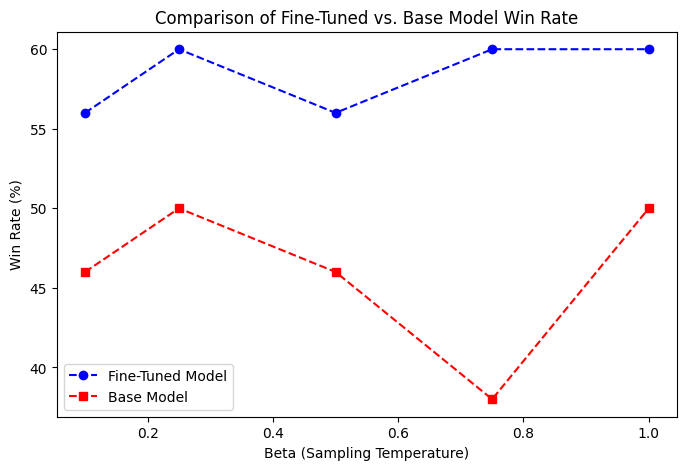

✅ Results saved to 'instruct_dpo_win_rate_comparison.csv'


In [31]:
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
fine_tuned_path = "mydpo-finetuned-instruct"
base_model_name = "gpt2-medium"

device = "cuda" if torch.cuda.is_available() else "cpu"

fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_path).to(device)
base_model = AutoModelForCausalLM.from_pretrained(base_model_name).to(device)

tokenizer = AutoTokenizer.from_pretrained(fine_tuned_path, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token


sbert_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to(device)

json_path = "./instruction-data-with-preference.json"
with open(json_path, "r") as f:
    data = json.load(f)

subset_size = 50
data = list(np.random.choice(data, size=min(subset_size, len(data)), replace=False))

eval_pairs = [{"prompt": row["instruction"]  + row["input"],
               "chosen": row["chosen"],
               "rejected": row["rejected"]} for row in data]

print(f"Loaded dataset with {len(eval_pairs)} examples.")

betas = [0.1, 0.25, 0.5, 0.75, 1.0]
win_rates_fine_tuned = []
win_rates_base = []

batch_size = 4

def evaluate_model(model, model_name):
    win_rates = []

    for beta in betas:
        correct = 0
        total = 0

        for i in range(0, len(eval_pairs), batch_size):
            batch = eval_pairs[i: i + batch_size]
            batch_prompts = [ex["prompt"] for ex in batch]
            batch_chosen_responses = [ex["chosen"] for ex in batch]
            batch_rejected_responses = [ex["rejected"] for ex in batch]

            inputs = tokenizer(batch_prompts, return_tensors="pt", truncation=True, padding=True).to(device)
            max_new_tokens = 30#min(50, int(len(inputs["input_ids"][0]) * 0.5))  # 50% of input size, max 30 tokens

            with torch.no_grad():
                outputs = model.generate(
                    inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=beta,
                    pad_token_id=tokenizer.eos_token_id
                )


            batch_generated_texts = []
            for i, output_ids in enumerate(outputs):
                # The prompt length is the length of inputs["input_ids"][i].
                prompt_len = inputs["input_ids"][i].shape[0]

                # Slice the output to skip the prompt tokens.
                gen_ids = output_ids[prompt_len:]
                
                # Decode only the newly generated portion.
                generated_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
                batch_generated_texts.append(generated_text)

            print(f"\n=== {model_name} | Beta: {beta:.2f} ===")
            for prompt, generated, chosen, rejected in zip(batch_prompts, batch_generated_texts, batch_chosen_responses, batch_rejected_responses):
                print(f"➡️ Prompt: {prompt}\n✅ Chosen: {chosen}\n❌ Rejected: {rejected}\n🔥 Generated: {generated}\n{'-'*60}")

            for generated, chosen, rejected in zip(batch_generated_texts, batch_chosen_responses, batch_rejected_responses):
                generated_embedding = sbert_model.encode(generated, convert_to_tensor=True)
                chosen_embedding = sbert_model.encode(chosen, convert_to_tensor=True)
                rejected_embedding = sbert_model.encode(rejected, convert_to_tensor=True)

                sim_generated_chosen = util.cos_sim(generated_embedding, chosen_embedding).item()
                sim_generated_rejected = util.cos_sim(generated_embedding, rejected_embedding).item()

                if sim_generated_chosen > sim_generated_rejected:
                    correct += 1

                total += 1

        win_rate = (correct / total) * 100
        win_rates.append(win_rate)
        print(f"✅ {model_name} | Beta={beta:.2f} => Win Rate: {win_rate:.2f}%")

    return win_rates

print("\n🔥 Evaluating Fine-Tuned Model...")
win_rates_fine_tuned = evaluate_model(fine_tuned_model, "Fine-Tuned Model")

print("\n🔥 Evaluating Base Model...")
win_rates_base = evaluate_model(base_model, "Base Model")

df_results = pd.DataFrame({
    "Beta": betas,
    "DPO Win Rate (%)": win_rates_fine_tuned,
    "Base Model Win Rate (%)": win_rates_base
})
df_results.to_csv("instruct_dpo_win_rate_comparison.csv", index=False)

plt.figure(figsize=(8, 5))
plt.plot(betas, win_rates_fine_tuned, marker="o", linestyle="--", color="b", label="DPO Model")
plt.plot(betas, win_rates_base, marker="s", linestyle="--", color="r", label="Base Model")
plt.xlabel("Beta (Sampling Temperature)")
plt.ylabel("Win Rate (%)")
plt.title("Comparison of DPO Win Rates with base mdoel")
plt.legend()
plt.show()

print("✅ Results saved to 'instruct_dpo_win_rate_comparison.csv'")


Loaded dataset with 500 examples.

🔥 Evaluating Fine-Tuned Model...

=== Fine-Tuned Model | Beta: 0.10 ===
➡️ Prompt: Generate a sentence using the word 'determined'.
✅ Chosen: She is very determined to achieve her dreams despite the obstacles.
❌ Rejected: She is determined to achieve her dreams despite the obstacles.
🔥 Generated: 

Answer: I am determined to achieve my goals.
------------------------------------------------------------
➡️ Prompt: Name a mammal that lays eggs.
✅ Chosen: A mammal that lays eggs is the platypus.
❌ Rejected: Obviously, a mammal that lays eggs is the platypus.
🔥 Generated: 

Answer: I'd be happy to help! Here are some suitable candidates for your consideration:
------------------------------------------------------------
➡️ Prompt: Name the device used to measure wind speed.
✅ Chosen: The device used to measure wind speed is an anemometer.
❌ Rejected: Obviously, it's an anemometer that measures wind speed.
🔥 Generated: 

Answer The device used to measure w

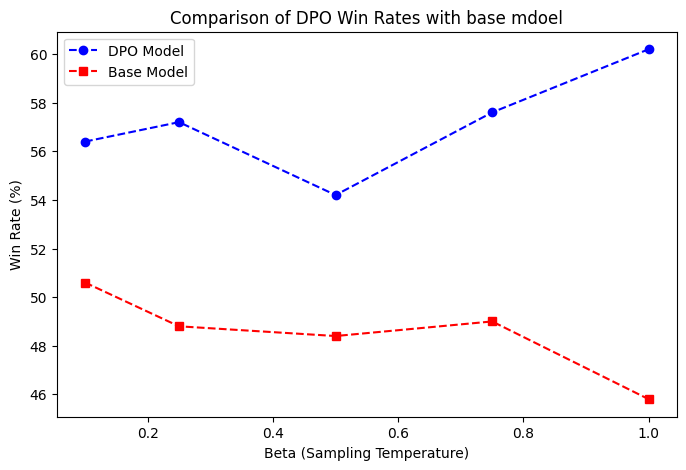

In [6]:
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
fine_tuned_path = "mydpo-finetuned-instruct"
base_model_name = "my-supervised-finetuned-gpt2"

device = "cuda" if torch.cuda.is_available() else "cpu"

fine_tuned_model = AutoModelForCausalLM.from_pretrained(fine_tuned_path).to(device)
base_model = AutoModelForCausalLM.from_pretrained(base_model_name).to(device)

tokenizer = AutoTokenizer.from_pretrained(fine_tuned_path, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token


sbert_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2").to(device)

json_path = "./instruction-data-with-preference.json"
with open(json_path, "r") as f:
    data = json.load(f)

subset_size = 500
data = list(np.random.choice(data, size=min(subset_size, len(data)), replace=False))

eval_pairs = [{"prompt": row["instruction"]  + row["input"],
               "chosen": row["chosen"],
               "rejected": row["rejected"]} for row in data]

print(f"Loaded dataset with {len(eval_pairs)} examples.")

betas = [0.1, 0.25, 0.5, 0.75, 1.0]
win_rates_fine_tuned = []
win_rates_base = []

batch_size = 4

def evaluate_model(model, model_name):
    win_rates = []

    for beta in betas:
        correct = 0
        total = 0

        for i in range(0, len(eval_pairs), batch_size):
            batch = eval_pairs[i: i + batch_size]
            batch_prompts = [ex["prompt"] for ex in batch]
            batch_chosen_responses = [ex["chosen"] for ex in batch]
            batch_rejected_responses = [ex["rejected"] for ex in batch]

            inputs = tokenizer(batch_prompts, return_tensors="pt", truncation=True, padding=True).to(device)
            max_new_tokens = 30#min(50, int(len(inputs["input_ids"][0]) * 0.5))  # 50% of input size, max 30 tokens

            with torch.no_grad():
                outputs = model.generate(
                    inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    temperature=beta,
                    pad_token_id=tokenizer.eos_token_id
                )


            batch_generated_texts = []
            for i, output_ids in enumerate(outputs):
                # The prompt length is the length of inputs["input_ids"][i].
                prompt_len = inputs["input_ids"][i].shape[0]

                # Slice the output to skip the prompt tokens.
                gen_ids = output_ids[prompt_len:]
                
                # Decode only the newly generated portion.
                generated_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
                batch_generated_texts.append(generated_text)

            print(f"\n=== {model_name} | Beta: {beta:.2f} ===")
            for prompt, generated, chosen, rejected in zip(batch_prompts, batch_generated_texts, batch_chosen_responses, batch_rejected_responses):
                print(f"➡️ Prompt: {prompt}\n Chosen: {chosen}\n Rejected: {rejected}\n Generated: {generated}\n{'-'*60}")

            for generated, chosen, rejected in zip(batch_generated_texts, batch_chosen_responses, batch_rejected_responses):
                generated_embedding = sbert_model.encode(generated, convert_to_tensor=True)
                chosen_embedding = sbert_model.encode(chosen, convert_to_tensor=True)
                rejected_embedding = sbert_model.encode(rejected, convert_to_tensor=True)

                sim_generated_chosen = util.cos_sim(generated_embedding, chosen_embedding).item()
                sim_generated_rejected = util.cos_sim(generated_embedding, rejected_embedding).item()

                if sim_generated_chosen > sim_generated_rejected:
                    correct += 1

                total += 1

        win_rate = (correct / total) * 100
        win_rates.append(win_rate)
        print(f"✅ {model_name} | Beta={beta:.2f} => Win Rate: {win_rate:.2f}%")

    return win_rates

print("\n🔥 Evaluating Fine-Tuned Model...")
win_rates_fine_tuned = evaluate_model(fine_tuned_model, "Fine-Tuned Model")

print("\n🔥 Evaluating Base Model...")
win_rates_base = evaluate_model(base_model, "Base Model")

df_results = pd.DataFrame({
    "Beta": betas,
    "DPO Win Rate (%)": win_rates_fine_tuned,
    "Base Model Win Rate (%)": win_rates_base
})
df_results.to_csv("instruct_dpo_win_rate_comparison.csv", index=False)

plt.figure(figsize=(8, 5))
plt.plot(betas, win_rates_fine_tuned, marker="o", linestyle="--", color="b", label="DPO Model")
plt.plot(betas, win_rates_base, marker="s", linestyle="--", color="r", label="Base Model")
plt.xlabel("Beta (Sampling Temperature)")
plt.ylabel("Win Rate (%)")
plt.title("Comparison of DPO Win Rates with base mdoel")
plt.legend()
plt.show()
